In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16
#from torchvision.io import VideoReader
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from decord import VideoReader, cpu
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from peft import get_peft_model, LoraConfig, TaskType
import os
from transformers import GPT2LMHeadModel, GPT2Model
import gc
from PIL import Image
import json
import math
from tqdm import tqdm
from typing import List, Tuple

In [2]:
# training hyperparams
BATCH_SIZE = 1
EPOCHS = 24
LR = 0.01

# video settings
RESOLUTION_WIDTH = 128
RESOLUTION_HEIGHT = 128
CHANNELS = 3
CONVERTED_FRAMERATE = 16

# model settings
WINDOW_SIZE = 46
ENCODED_DIM = 2048

# misc pytorch settings
run_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RUN_NAME = "exp11"
TENSORBOARD_LOG_DIR = "runs/" + RUN_NAME

In [3]:
class PerceptualLoss(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        vgg = vgg16(pretrained=True).features.eval()

        for layer in vgg:
            if isinstance(layer, nn.ReLU):
                layer.inplace = False

        self.vgg = vgg
        for param in self.vgg.parameters():
            param.requires_grad = False

        # Selected layers: low-level to mid-level features
        self.layers = {
            "0": "relu1_1",
            "3": "relu1_2",
            "8": "relu2_2",
            "15": "relu3_3"
        }

        # Prioritize early edges more explicitly
        self.layer_weights = weights or {
            "relu1_1": 2.0,
            "relu1_2": 1.5,
            "relu2_2": 0.7,
            "relu3_3": 0.2,
        }

    def forward(self, x, y):
        loss = 0.0
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            y = layer(y)
            name = self.layers.get(str(i))
            if name:
                weight = self.layer_weights[name]
                loss += weight * F.mse_loss(x, y)
            if i > max(map(int, self.layers.keys())):
                break
        return loss

class CombinedLoss(nn.Module):
    def __init__(self, perceptual_weight=0.7, mse_weight=1.4):
        super().__init__()
        self.perceptual_loss = PerceptualLoss()
        self.mse_loss = nn.MSELoss()
        self.perceptual_weight = perceptual_weight
        self.mse_weight = mse_weight

    def forward(self, reconstructed_images, target_images):
        return (
            self.perceptual_weight * self.perceptual_loss(reconstructed_images, target_images)
            + self.mse_weight * self.mse_loss(reconstructed_images, target_images)
        )

loss_fn = CombinedLoss()
loss_fn = loss_fn.to(run_device)

c:\Users\user\anaconda3\envs\condavnv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\condavnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels=CHANNELS, latent_dim=ENCODED_DIM, input_resolution=(RESOLUTION_WIDTH, RESOLUTION_HEIGHT)):
        super().__init__()

        self.input_resolution = input_resolution
        self.latent_dim = latent_dim

        # encoder cnn
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),           # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),          # 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),         # 8x8
            nn.ReLU()
        )

        # calc the output dimension after the convolutional layers dynamically
        self._conv_output_dim = 256 * (input_resolution[0] // 16) * (input_resolution[1] // 16)
        
        # encoder linear
        self.encoder_fc = nn.Sequential(
            nn.Linear(self._conv_output_dim, latent_dim),
            nn.Tanh() # tanh to scale the latents to [-1, 1] range
        )

        # decoder linear
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, self._conv_output_dim)
        )

        # decoder cnn
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.Sigmoid() # sigmoid to scale the output to [0, 1] range
        )

    def encode(self, x):
        # if a sequence of frames came in, flatten the batch and sequence dimensions to pass thru conv
        original_shape = x.shape[:-3]
        x = x.view(-1, *x.shape[-3:])

        x = self.encoder_cnn(x)
        x = x.view(x.size(0), -1)
        z = self.encoder_fc(x)

        # reshape z back to original batch and sequence dimensions (if there were any)
        z = z.view(*original_shape, self.latent_dim)  # reshape back

        return z

    def decode(self, z):
        # if a sequence of latents came in, flatten the batch and sequence dimensions to pass thru deconv
        original_shape = z.shape[:-1]
        z = z.view(-1, self.latent_dim)

        x = self.decoder_fc(z)
        x = x.view(-1, 256, self.input_resolution[0] // 16, self.input_resolution[1] // 16)
        x = self.decoder_cnn(x)

        # reshape z back to original batch and sequence dimensions (if there were any)
        x = x.view(*original_shape, *x.shape[1:])
        
        return x

In [5]:
# autoencoder testing

In [6]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import glob
from tqdm import tqdm
import torch

class PreloadedImageDataset(Dataset):
    def __init__(self, root_dir="./data", image_size=(128, 128)):
        self.image_paths = glob.glob(os.path.join(root_dir, "*.jpg"))
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),  # [0, 1] and channels first
        ])

        print(f"Preloading {len(self.image_paths)} images into memory...")
        self.images = []
        for path in tqdm(self.image_paths):
            try:
                img = Image.open(path).convert("RGB")
                self.images.append(self.transform(img))
            except Exception as e:
                print(f"Error loading {path}: {e}")

        self.images = torch.stack(self.images)  # optional: for faster access

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]


In [7]:
dataset = PreloadedImageDataset(root_dir="./data", image_size=(128, 128))
loader = DataLoader(dataset, batch_size=16, shuffle=True)

Preloading 3000 images into memory...


  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:03<00:00, 973.71it/s] 


In [8]:
model = Autoencoder().to(run_device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)

num_epochs = 500

for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        batch = batch.to(run_device)

        optimizer.zero_grad()
        encoded = model.encode(batch)
        decoded = model.decode(encoded)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch}: Avg Loss = {avg_loss:.6f}")

Epoch 0: Avg Loss = 0.065132
Epoch 1: Avg Loss = 0.049805
Epoch 2: Avg Loss = 0.031173
Epoch 3: Avg Loss = 0.027392
Epoch 4: Avg Loss = 0.025199
Epoch 5: Avg Loss = 0.023839
Epoch 6: Avg Loss = 0.022764
Epoch 7: Avg Loss = 0.021587
Epoch 8: Avg Loss = 0.019641
Epoch 9: Avg Loss = 0.018331
Epoch 10: Avg Loss = 0.017542
Epoch 11: Avg Loss = 0.016881
Epoch 12: Avg Loss = 0.016318
Epoch 13: Avg Loss = 0.015897
Epoch 14: Avg Loss = 0.015489
Epoch 15: Avg Loss = 0.015059
Epoch 16: Avg Loss = 0.014633
Epoch 17: Avg Loss = 0.014227
Epoch 18: Avg Loss = 0.013871
Epoch 19: Avg Loss = 0.013556
Epoch 20: Avg Loss = 0.013168
Epoch 21: Avg Loss = 0.012913
Epoch 22: Avg Loss = 0.012620
Epoch 23: Avg Loss = 0.012435
Epoch 24: Avg Loss = 0.012118
Epoch 25: Avg Loss = 0.011924


KeyboardInterrupt: 

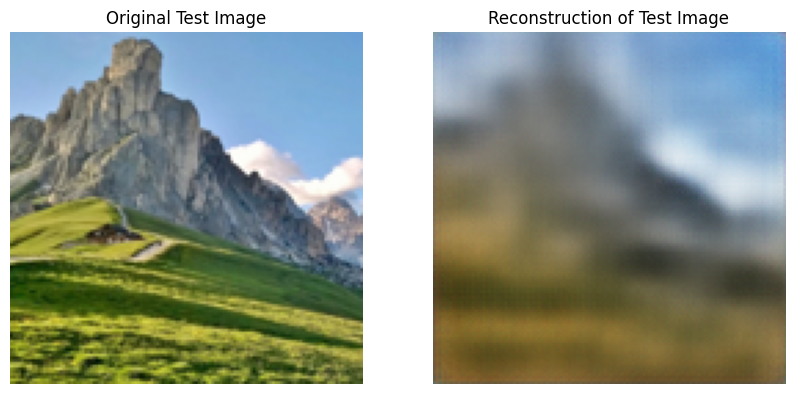

In [9]:
# run "./test.png thru the autoencoder and show the result"

import matplotlib.pyplot as plt

# Load an image and preprocess it
test_image_path = "./test.png"
test_image = Image.open(test_image_path).convert('RGB')
test_image = test_image.resize((RESOLUTION_WIDTH, RESOLUTION_HEIGHT))
test_image_tensor = T.ToTensor()(test_image).unsqueeze(0).to(run_device)  # shape: (1, 3, 128, 128)
# Run the autoencoder on the test image
with torch.no_grad():
    test_recon = model.decode(model.encode(test_image_tensor)).squeeze()
def show_image(tensor, title):
    plt.imshow(tensor.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
show_image(test_image_tensor.squeeze(), "Original Test Image")
plt.subplot(1, 2, 2)
show_image(test_recon.clamp(0, 1), "Reconstruction of Test Image")
plt.show()